# Dataset2 - Classification

In [1]:
#basic setup libraries
import numpy as np
import pandas as pd
from reading_data_helper_functions import read_dataset_file, get_head_with_pandas
from eda_helper_functions import get_dataframe_info, plot_class_count_bar_graph
import time

#plot graph libraries
import seaborn as sns
import matplotlib.pyplot as plt

#standardizing value library
from sklearn.preprocessing import StandardScaler

#resampling tecniques
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

#classification libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

#metrics to measure the classification
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_auc_score, classification_report, accuracy_score, roc_curve

#helper functions
from classification_helper_functions import perform_30_70_undersampling, perform_70_30_oversampling, perform_70_30_smote, evaluate_classifier

Read in the file for dataset2. 

In [2]:
#using dataset 2 for the development of the algorithm

filename = "creditcard.csv"

dataset = read_dataset_file(filename) #helper function
get_head_with_pandas(dataset) #helper function

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


Standardize the Amount column and drop irrelevant columns.

In [3]:
#normalize the column 'Amount'
dataset['normAmount'] = StandardScaler().fit_transform(dataset['Amount'].values.reshape(-1, 1))
#dataset.head(5)

#drop the columns 'Time' and 'Amount'
dataset = dataset.drop(['Time','Amount'],axis=1)

Assigning values to split for train/test data. It is at this point, the deciding factor for the target should be determined. If the target column is not named 'Class', it should be done so to reduce conflicts within the Undersampling technique.

In [4]:
#assigning values to X and y for split train/test

inputs = dataset.drop("Class", axis=1).copy()
target = dataset["Class"]

X = inputs#.values
y = target#.values

Initializing the classifiers and splitting the data into 70% training and 30% testing. As observed in previous analysis, this particular data set is highly imbalanced. This is to ensure enough data is used for training while still having a reletive amount of data for testing. This is performed outside of each if statement, so that each resampling techniques occur on the same training/testing dataset.

In [5]:
log_reg = LogisticRegression()
rf = RandomForestClassifier()
svm = SVC()

fraud_data = len(dataset[dataset.Class == 1])
normal_data = len(dataset[dataset.Class == 0])

#split the data to 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.3, shuffle=True)

#### Performing Resampling Techniques
From the data split, the collective dataframe is test to determine whether it is balanced or imbalanced. If the data frame is imbalanced, resampling techniques will be performed onto the training data. A ratio of 70:30 is selected to ensure sufficient training data with a relvant amount testing data. Else, a standard ratio of 80:20 is used to perform on the balanced dataframe. The three classifiers chosen are run against the resampled data and timed to which will then determine the more suitable classifier to perform on the testing data. It should be noted that each of the resampling techniques are run separately to reduce conflicts with the kernel. 

##### Undersampling

This data frame is imbalanced.

Performing 70:30 undersampling ...
normal transactions:  830
fraud transactions:  356
Total number of transactions in resampled data:  1186
# train records: 830
# test records: 356


Logistic Regression
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       265
           1       0.96      0.86      0.91        91

    accuracy                           0.96       356
   macro avg       0.96      0.92      0.94       356
weighted avg       0.96      0.96      0.95       356

Accuracy Score: 0.955
Recall Score: 0.857
F1 Score: 0.907
ROC AUC Score: 0.968


c:\Users\anura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


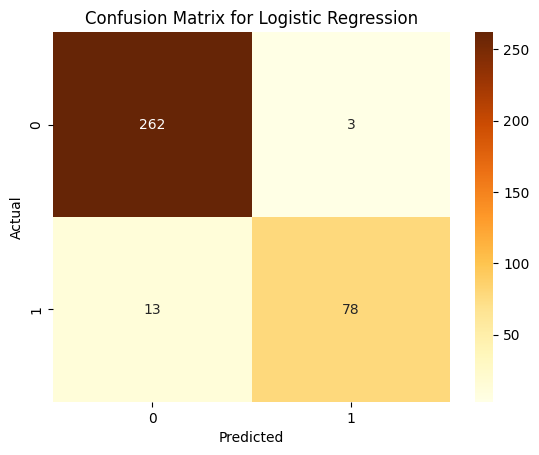

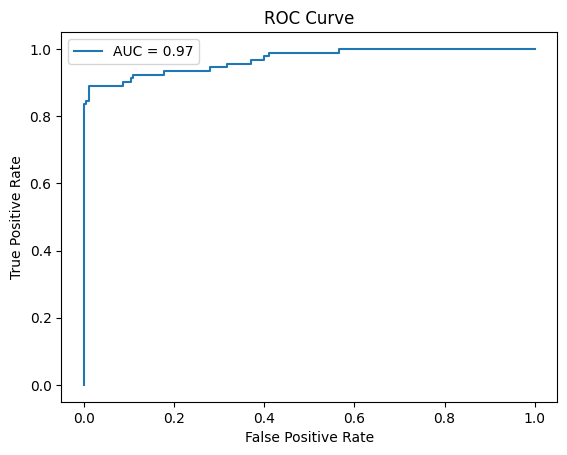

Process took 0.240 seconds.

# train records: 830
# test records: 356



c:\Users\anura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Random Forest
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       265
           1       0.97      0.85      0.91        91

    accuracy                           0.96       356
   macro avg       0.96      0.92      0.94       356
weighted avg       0.96      0.96      0.95       356

Accuracy Score: 0.955
Recall Score: 0.846
F1 Score: 0.906
ROC AUC Score: 0.967


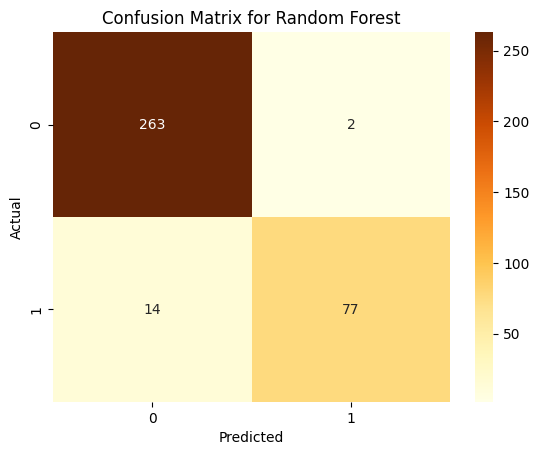

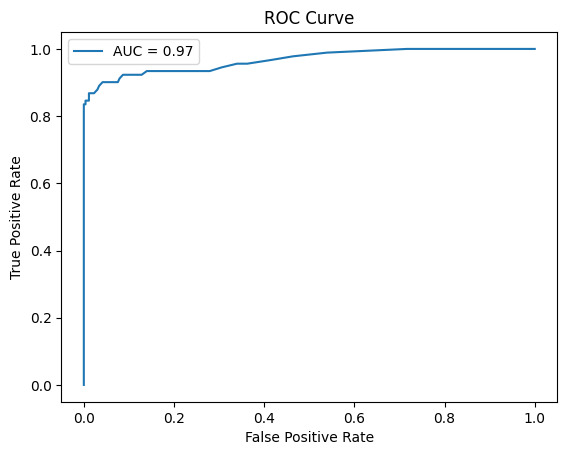

Process took 0.488 seconds.

# train records: 830
# test records: 356


Linear SVM
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       265
           1       0.99      0.84      0.90        91

    accuracy                           0.96       356
   macro avg       0.97      0.92      0.94       356
weighted avg       0.96      0.96      0.95       356

Accuracy Score: 0.955
Recall Score: 0.835
F1 Score: 0.905
ROC AUC Score: 0.976


c:\Users\anura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


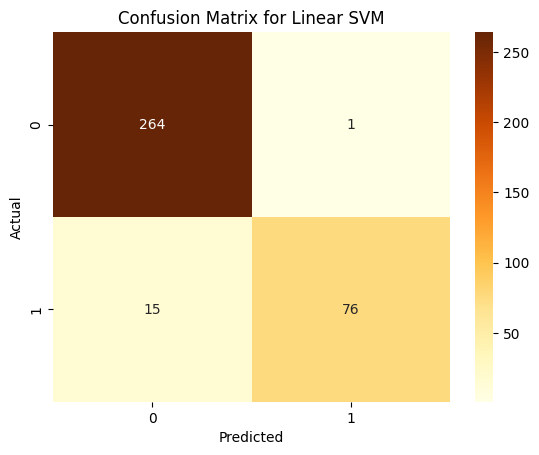

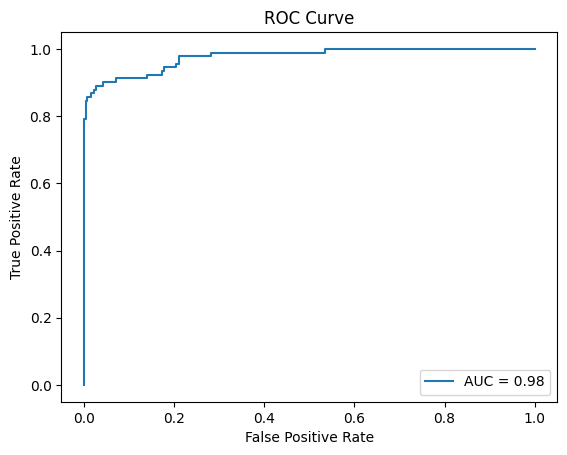

Process took 0.229 seconds.



In [6]:
if (fraud_data != normal_data):
    print("This data frame is imbalanced.\n")

    #perform resampling
    print("Performing 70:30 undersampling ...")
    under_sample_X, under_sample_y = perform_30_70_undersampling(X_train, y_train) # resample training
    X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(under_sample_X ,under_sample_y ,test_size = 0.3 ,random_state = 0)
    under_sample_values = X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample # group values

    log_start_time = time.time()
    evaluate_classifier(under_sample_values, log_reg, "Logistic Regression")
    log_end_time = time.time()
    print(f"Process took {log_end_time - log_start_time:.3f} seconds.\n")

    rf_start_time = time.time()
    evaluate_classifier(under_sample_values, rf, "Random Forest")
    rf_end_time = time.time()
    print(f"Process took {rf_end_time - rf_start_time:.3f} seconds.\n")

    svm_start_time = time.time()
    evaluate_classifier(under_sample_values, svm, "Linear SVM")
    svm_end_time = time.time()
    print(f"Process took {svm_end_time - svm_start_time:.3f} seconds.\n")
else:
    print("The data frame is balanced.\n")
    #split the data to 80:20
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.2, shuffle=True)
    normal_values = X_train, X_test, y_train, y_test

    log_start_time = time.time()
    evaluate_classifier(normal_values, log_reg, "Logistic Regression")
    log_end_time = time.time()
    print(f"Process took {log_end_time - log_start_time:.3f} seconds.\n")

    rf_start_time = time.time()
    evaluate_classifier(normal_values, rf, "Random Forest")
    rf_end_time = time.time()
    print(f"Process took {rf_end_time - rf_start_time:.3f} seconds.\n")

    svm_start_time = time.time()
    evaluate_classifier(normal_values, svm, "Linear SVM")
    svm_end_time = time.time()
    print(f"Process took {svm_end_time - svm_start_time:.3f} seconds.\n")

##### Oversampling Technique

This data frame is imbalanced.

Performing 70:30 oversampling ...
After OverSampling, counts of label '1': 83583
After OverSampling, counts of label '0': 199008


c:\Users\anura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\anura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


# train records: 197813
# test records: 84778


Logistic Regression
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     59703
           1       0.97      0.89      0.93     25075

    accuracy                           0.96     84778
   macro avg       0.97      0.94      0.95     84778
weighted avg       0.96      0.96      0.96     84778

Accuracy Score: 0.961
Recall Score: 0.891
F1 Score: 0.931
ROC AUC Score: 0.986


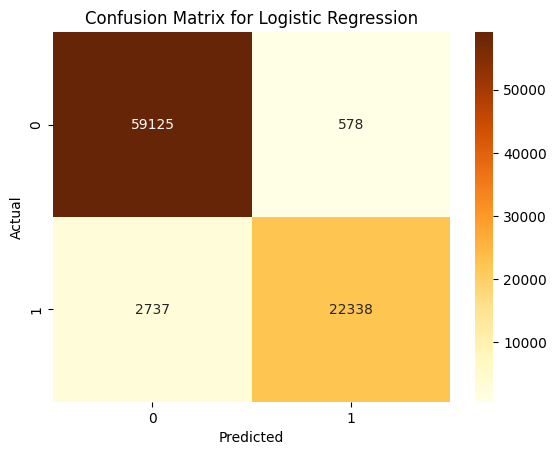

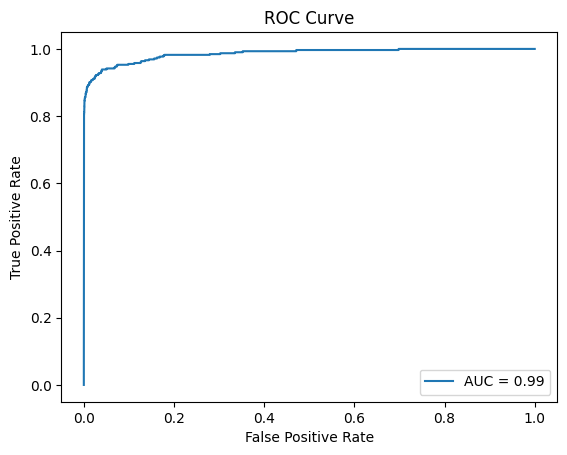

Process took 1.037 seconds.

# train records: 197813
# test records: 84778


Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59703
           1       1.00      1.00      1.00     25075

    accuracy                           1.00     84778
   macro avg       1.00      1.00      1.00     84778
weighted avg       1.00      1.00      1.00     84778

Accuracy Score: 1.000
Recall Score: 1.000
F1 Score: 1.000
ROC AUC Score: 1.000


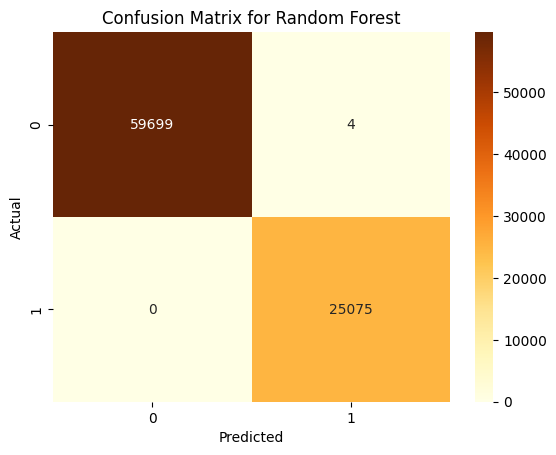

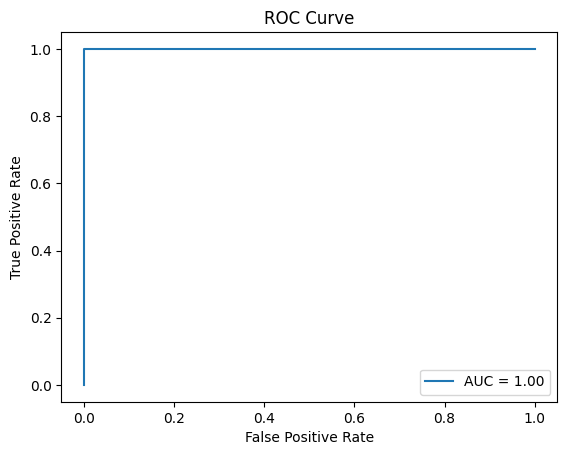

Process took 91.739 seconds.

# train records: 197813
# test records: 84778


Linear SVM
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     59703
           1       0.99      0.93      0.96     25075

    accuracy                           0.98     84778
   macro avg       0.98      0.97      0.97     84778
weighted avg       0.98      0.98      0.98     84778

Accuracy Score: 0.978
Recall Score: 0.935
F1 Score: 0.962
ROC AUC Score: 0.998


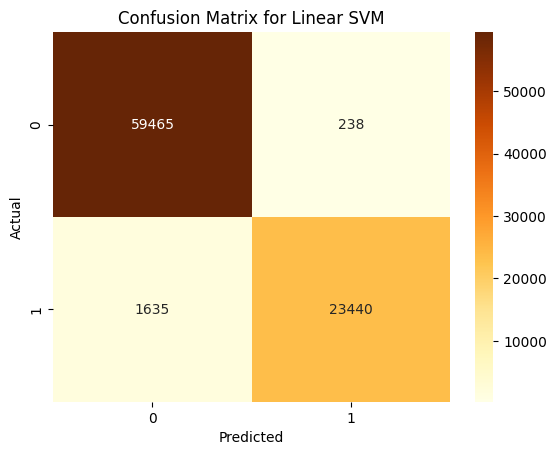

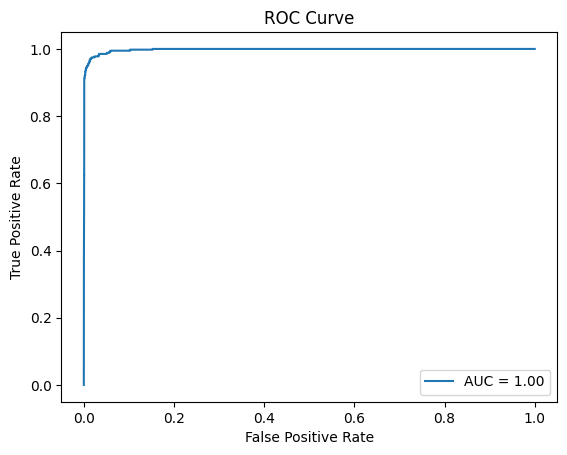

Process took 406.456 seconds.



In [7]:
if (fraud_data != normal_data):
    print("This data frame is imbalanced.\n")

    #perform resampling
    print("Performing 70:30 oversampling ...")
    over_sample_X, over_sample_y = perform_70_30_oversampling(X_train, y_train)
    X_train_oversample, X_test_oversample, y_train_oversample, y_test_oversample = train_test_split(over_sample_X ,over_sample_y ,test_size = 0.3 ,random_state = 0)
    over_sample_values = X_train_oversample, X_test_oversample, y_train_oversample, y_test_oversample

    log_start_time = time.time()
    evaluate_classifier(over_sample_values, log_reg, "Logistic Regression")
    log_end_time = time.time()
    print(f"Process took {log_end_time - log_start_time:.3f} seconds.\n")

    rf_start_time = time.time()
    evaluate_classifier(over_sample_values, rf, "Random Forest")
    rf_end_time = time.time()
    print(f"Process took {rf_end_time - rf_start_time:.3f} seconds.\n")

    svm_start_time = time.time()
    evaluate_classifier(over_sample_values, svm, "Linear SVM")
    svm_end_time = time.time()
    print(f"Process took {svm_end_time - svm_start_time:.3f} seconds.\n")    
else:
    print("The data frame is balanced.\n")
    #split the data to 80:20
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.2, shuffle=True)
    normal_values = X_train, X_test, y_train, y_test

    log_start_time = time.time()
    evaluate_classifier(normal_values, log_reg, "Logistic Regression")
    log_end_time = time.time()
    print(f"Process took {log_end_time - log_start_time:.3f} seconds.\n")

    rf_start_time = time.time()
    evaluate_classifier(normal_values, rf, "Random Forest")
    rf_end_time = time.time()
    print(f"Process took {rf_end_time - rf_start_time:.3f} seconds.\n")

    svm_start_time = time.time()
    evaluate_classifier(normal_values, svm, "Linear SVM")
    svm_end_time = time.time()
    print(f"Process took {svm_end_time - svm_start_time:.3f} seconds.\n")


##### SMOTE

This data frame is imbalanced.
Performing 70:30 SMOTE ...


c:\Users\anura\Documents\UWI - COMP3608 - Intelligent Systems\A - Project\Dataset2\classification_helper_functions.py:133: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_smote, y_smote = sm.fit_resample(X_train, y_train.ravel())
c:\Users\anura\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


After SMOTE, counts of label '1': 83583
After SMOTE, counts of label '0': 199008
# train records: 197813
# test records: 84778


Logistic Regression
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     59703
           1       0.97      0.89      0.93     25075

    accuracy                           0.96     84778
   macro avg       0.97      0.94      0.95     84778
weighted avg       0.96      0.96      0.96     84778

Accuracy Score: 0.961
Recall Score: 0.891
F1 Score: 0.931
ROC AUC Score: 0.986


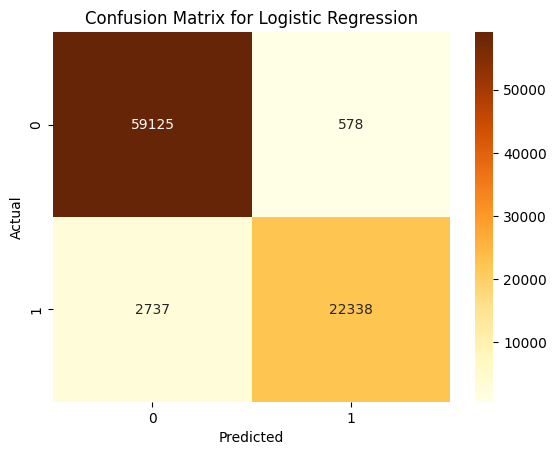

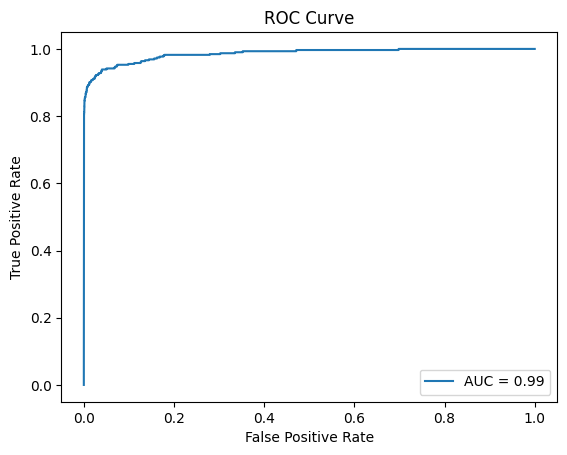

Process took 0.927 seconds.

# train records: 197813
# test records: 84778


Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59703
           1       1.00      1.00      1.00     25075

    accuracy                           1.00     84778
   macro avg       1.00      1.00      1.00     84778
weighted avg       1.00      1.00      1.00     84778

Accuracy Score: 1.000
Recall Score: 1.000
F1 Score: 1.000
ROC AUC Score: 1.000


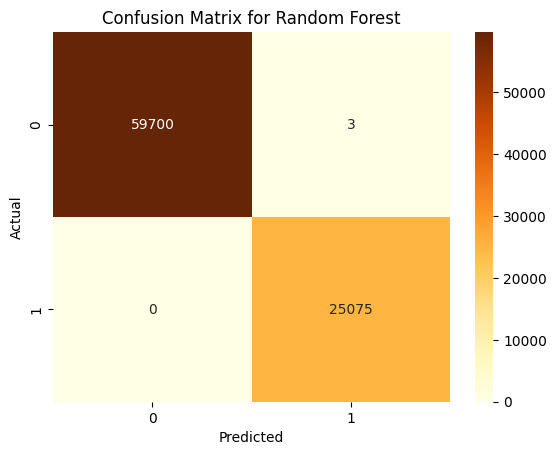

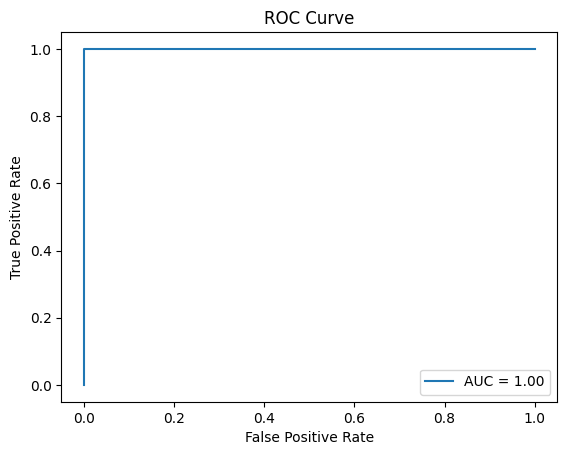

Process took 82.851 seconds.

# train records: 197813
# test records: 84778


Linear SVM
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     59703
           1       0.99      0.93      0.96     25075

    accuracy                           0.98     84778
   macro avg       0.98      0.97      0.97     84778
weighted avg       0.98      0.98      0.98     84778

Accuracy Score: 0.978
Recall Score: 0.935
F1 Score: 0.962
ROC AUC Score: 0.998


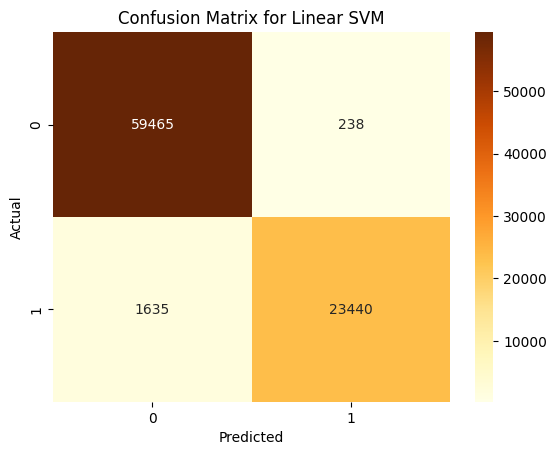

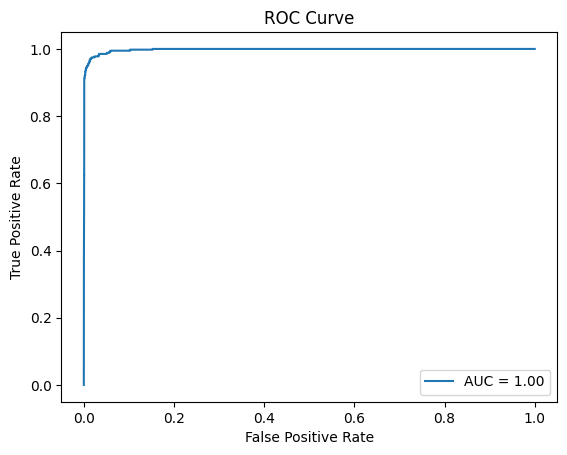

Process took 409.531 seconds.



In [8]:
if (fraud_data != normal_data):
    print("This data frame is imbalanced.")

    #perform resampling
    print("Performing 70:30 SMOTE ...")
    smote_sample_X, smote_sample_y = perform_70_30_smote(X_train, y_train)
    X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(over_sample_X ,over_sample_y ,test_size = 0.3 ,random_state = 0)
    smote_sample_values = X_train_smote, X_test_smote, y_train_smote, y_test_smote

    log_start_time = time.time()
    evaluate_classifier(smote_sample_values, log_reg, "Logistic Regression")
    log_end_time = time.time()
    print(f"Process took {log_end_time - log_start_time:.3f} seconds.\n")

    rf_start_time = time.time()
    evaluate_classifier(smote_sample_values, rf, "Random Forest")
    rf_end_time = time.time()
    print(f"Process took {rf_end_time - rf_start_time:.3f} seconds.\n")

    svm_start_time = time.time()
    evaluate_classifier(smote_sample_values, svm, "Linear SVM")
    svm_end_time = time.time()
    print(f"Process took {svm_end_time - svm_start_time:.3f} seconds.\n")
else:
    print("The data frame is balanced.\n")
    #split the data to 80:20
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.2, shuffle=True)
    normal_values = X_train, X_test, y_train, y_test

    log_start_time = time.time()
    evaluate_classifier(normal_values, log_reg, "Logistic Regression")
    log_end_time = time.time()
    print(f"Process took {log_end_time - log_start_time:.3f} seconds.\n")

    rf_start_time = time.time()
    evaluate_classifier(normal_values, rf, "Random Forest")
    rf_end_time = time.time()
    print(f"Process took {rf_end_time - rf_start_time:.3f} seconds.\n")

    svm_start_time = time.time()
    evaluate_classifier(normal_values, svm, "Linear SVM")
    svm_end_time = time.time()
    print(f"Process took {svm_end_time - svm_start_time:.3f} seconds.\n")


#### Inferences

From the graphs above, it can be noted that the classifier 'Random Forest' yields a perfect score of 1.00 for the majority of resampling techniques. Therefore the more suitable classifier for this dataset is Random Forest. Though the scores are higher, it should be noted that some of the data may be overlooked during the initial sample. Steps, such as changes the random state or running the training/test split can provide other insights.

##### Performing the chosen Classifier Random Forest for the General dataframe

# train records: 199364
# test records: 85443


Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.95      0.79      0.86       136

    accuracy                           1.00     85443
   macro avg       0.97      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy Score: 1.000
Recall Score: 0.794
F1 Score: 0.864
ROC AUC Score: 0.969


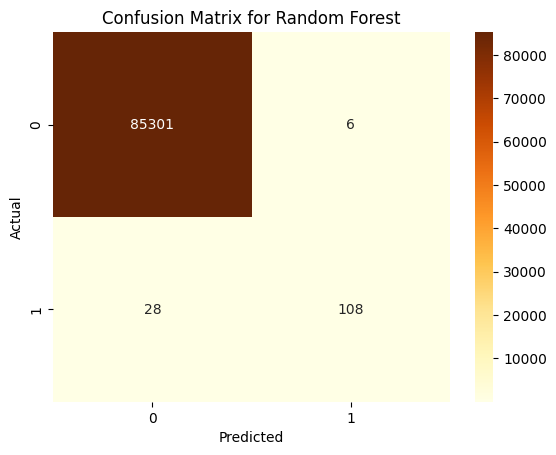

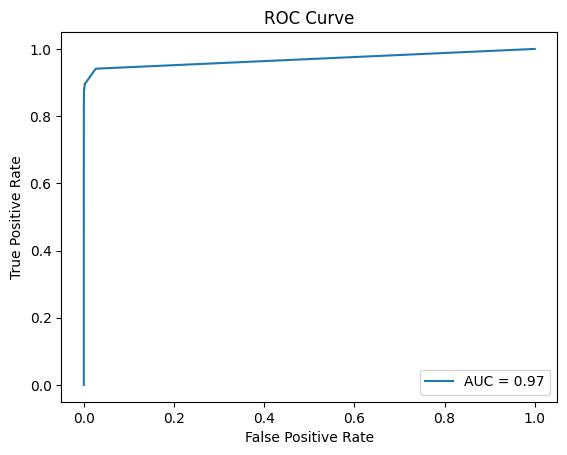

Process took 165.295 seconds.



In [9]:
normal_values = X_train, X_test, y_train, y_test

rf_start_time = time.time()
evaluate_classifier(normal_values, rf, "Random Forest")
rf_end_time = time.time()
print(f"Process took {rf_end_time - rf_start_time:.3f} seconds.\n")